# Library

In [1]:
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

------

# Utils

In [2]:
system= "colab"

if system== "local":
    drive_path= r"./"

elif system== "colab":
    drive_path= r"/content/drive/MyDrive/Catalist/0_age estimation/"

In [3]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


--------

# Data

## load image

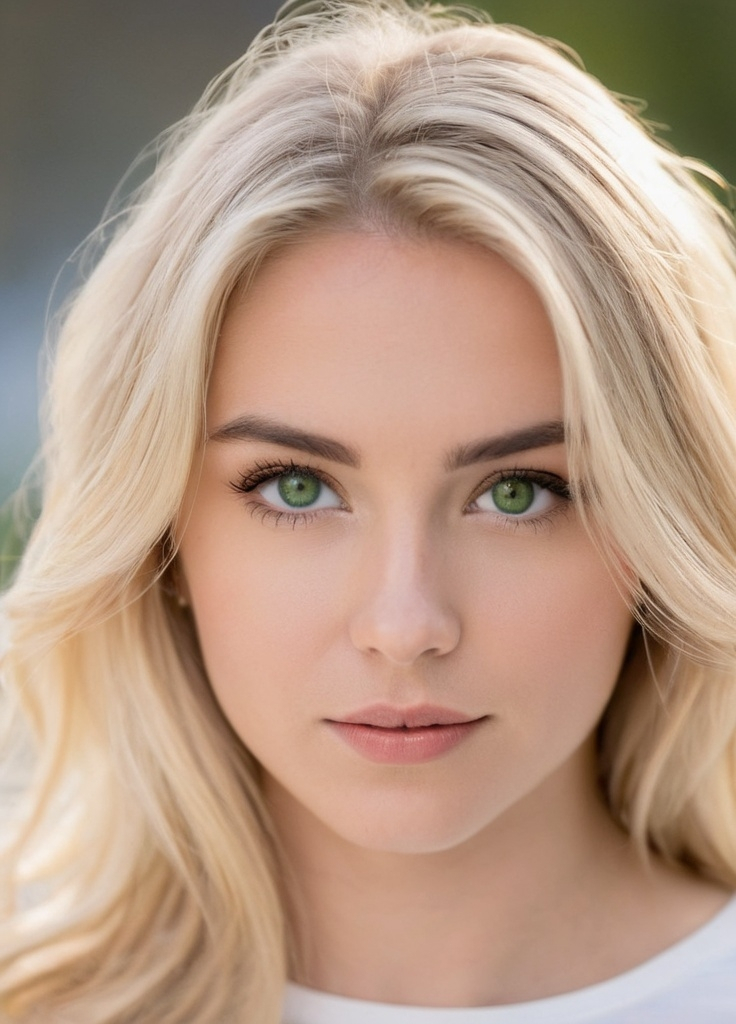

In [5]:
img= Image.open('image.jpg')
img

## crop face

In [6]:
def crop_faces(image_path, output_folder):
    face_cascade= cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img= cv2.imread(image_path)
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces= face_cascade.detectMultiScale(gray, 1.1, 4)

    x, y, w, h= faces[0]
    face= img[y:y+h, x:x+w]
    output_path= os.path.join(output_folder, f'face_crop.jpg')
    cv2.imwrite(output_path, face)

    return len(faces)

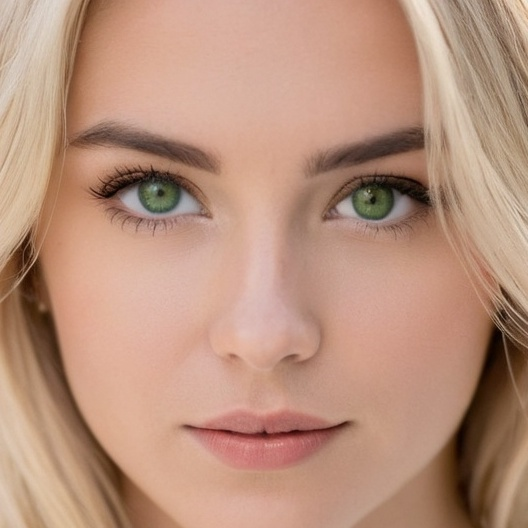

In [7]:
crop_faces('image.jpg', '/content')
img= Image.open('face_crop.jpg')
img

## transform

In [8]:
image_transform= transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
])

-------

# Model

In [9]:
class Age_estimator(nn.Module):
  def __init__(self):
    super().__init__()
    self.Model= models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2)
    self.Model.fc= nn.LazyLinear(1)

  def forward(self, x):
    y= self.Model(x)
    return y

class GR_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.Model= models.resnet18(weights= models.ResNet18_Weights.IMAGENET1K_V1)
    self.Model.fc= nn.Identity()
    self.gender_fc= nn.LazyLinear(2)
    self.race_fc= nn.LazyLinear(5)

  def forward(self, x):
    y= self.Model(x)
    y_gender= self.gender_fc(y)
    y_race= self.race_fc(y)
    return y_gender, y_race

In [10]:
age_model= torch.load(os.path.join(drive_path, "age_model.pt"), map_location= device)
age_model.eval()
gr_model= torch.load(os.path.join(drive_path, "gr_model.pt"), map_location= device)
gr_model.eval();

<ipython-input-10-e3c1bf531a35>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  age_model= torch.load(os.path.join(drive_path, "age_model.pt"), map_location= device)
<ipyth

-----------

# Prediction

In [11]:
gender_map= {'Male': 0, 'Female': 1}
race_map= {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}
reverse_gender_map= {v: k for k, v in gender_map.items()}
reverse_race_map= {v: k for k, v in race_map.items()}

Age between 12 and 16 years.
sex: Female,
race: White


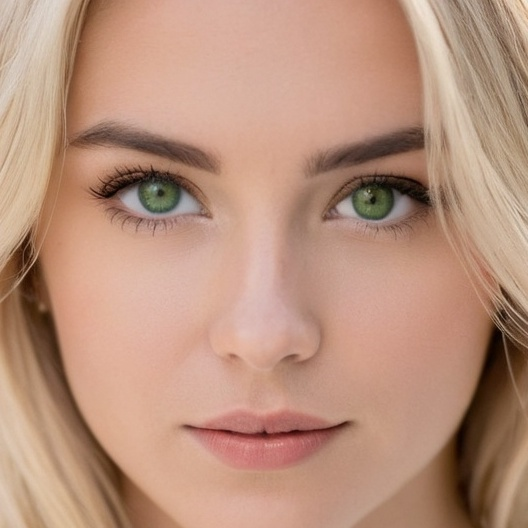

In [12]:
with torch.inference_mode():
  age= age_model(image_transform(img).unsqueeze(0))
  gender, race= gr_model(image_transform(img).unsqueeze(0))
print(f'Age between {age.item()-2:.0f} and {age.item()+2:.0f} years.')
print(f"sex: {reverse_gender_map[int(torch.argmax(gender))]},")
print(f'race: {reverse_race_map[int(torch.argmax(race))]}')
img